# Raw data study and visualisation

In [ ]:
from sqlalchemy import create_engine
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta, date, datetime
from time import time
import matplotlib.ticker as tkr
from scipy import stats
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from pylab import rcParams
from statsmodels.tsa.seasonal import STL

%matplotlib inline

In [ ]:
!pip install statsmodels --upgrade

### Import datat from the database

In [ ]:
from google.colab import files
import io
uploaded = files.upload()

In [ ]:
df=pd.read_csv(io.BytesIO(uploaded['Global DataBase.csv']), index_col='datetime', parse_dates=True, dayfirst=True)
df = df.sort_index()
#df[['Price - PT [€/MWh]']] = df[['Price - PT [€/MWh]']].diff

In [ ]:
#Handeling global outliers, none in our case
GlobalOutliers =  []
for i in range(0):
    print(df.idxmax()['Price - PT [€/MWh]'])
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()

In [ ]:
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']

### Adding the year, quarter, month and day features

In [ ]:
df = df.reset_index(drop=False)

df['Time']=pd.to_datetime(df['datetime']) 
#DatetimeIndex, which is a pandas index that is optimized to index data with dates and times.
df['year'] = df['Time'].apply(lambda x: x.year)
df['quarter'] = df['Time'].apply(lambda x: x.quarter)
df['month'] = df['Time'].apply(lambda x: x.month)
df['day'] = df['Time'].apply(lambda x: x.day)


df=df.loc[:,['Time','Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC', 'Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA', 'Wind Onshore AA','Electricity Consumption (MWh)', 'Season', 'year', 'quarter','month', 'day']]
df.columns = ['Time','Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC', 'Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA', 'Wind Onshore AA','Electricity Consumption (MWh)', 'Season', 'year', 'quarter','month', 'day']


### Zero values detection

In [ ]:
df.set_index("Time", inplace=True)

In [ ]:
df_PricePT = df['Price - PT [€/MWh]'].dropna()
df_PriceES = df['Price - ES [€/MWh]'].dropna()

In [ ]:
df_zPricePT = (df['Price - PT [€/MWh]']==0)

print(df_zPricePT.count())
print("*****************************************************************************")


df_zPricePTm = df_zPricePT.groupby(df_zPricePT.index.month).size().reset_index(name='counts')

print(df_zPricePTm)
print("*****************************************************************************")

45599
45599
*****************************************************************************
    Time  counts
0      1    4463
1      2    4056
2      3    4080
3      4    3600
4      5    3720
5      6    3600
6      7    3720
7      8    3720
8      9    3600
9     10    3720
10    11    3600
11    12    3720
*****************************************************************************
    Time  counts
0      1    4463
1      2    4056
2      3    4080
3      4    3600
4      5    3720
5      6    3600
6      7    3720
7      8    3720
8      9    3600
9     10    3720
10    11    3600
11    12    3720


In [ ]:
df = df.reset_index(drop=False)

### Monthly and Daily load in boxplots

Text(0, 0.5, 'Consumption')

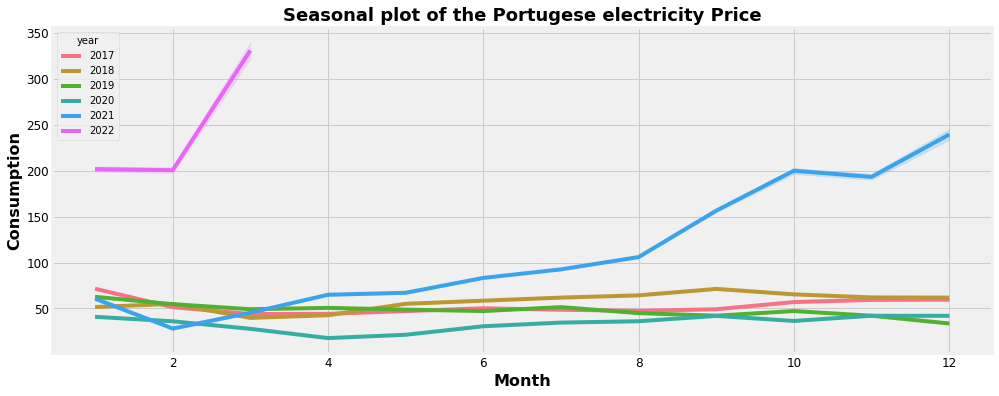

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("husl", 6)
sns.lineplot(df['month'], df["Price - PT [€/MWh]"], hue=df['year'], palette=palette)
ax.set_title('Seasonal plot of the Portugese electricity Price', fontsize = 18, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Consumption', fontsize = 16, fontdict=dict(weight='bold'))

Text(0, 0.5, 'Consumption')

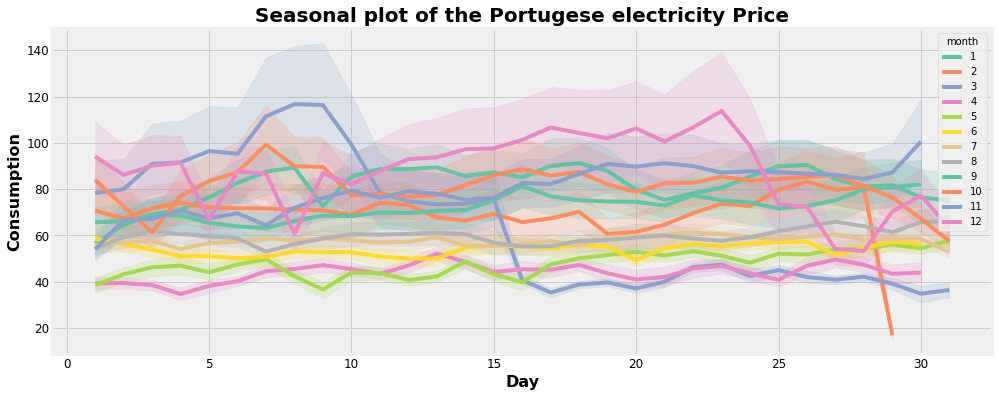

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("Set2", 12)
sns.lineplot(df['day'], df["Price - PT [€/MWh]"], hue=df['month'], palette=palette)
ax.set_title('Seasonal plot of the Portugese electricity Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Day', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Consumption', fontsize = 16, fontdict=dict(weight='bold'))

In [ ]:
df.set_index("Time", inplace=True)

In [ ]:
def perform_adf_test(series, column):
    result = adfuller(series)
    print("************* ADF test for "+ column +" data *************")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [ ]:
dfPricePT1 = df.loc["2017-01-01 00:00:00":"2022-12-03 23:00:00"]["Price - PT [€/MWh]"].dropna()

In [ ]:
#perform augmented Dickey-Fuller test
perform_adf_test(dfPricePT1, "Price - PT [€/MWh]")

************* ADF test for Price - PT [€/MWh] data *************
ADF Statistic: -3.961369
p-value: 0.001627
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [ ]:
dfPricePT1 = dfPricePT1.diff().dropna()

In [ ]:
#perform augmented Dickey-Fuller test
perform_adf_test(dfPricePT1, "Price - PT [€/MWh]")

************* ADF test for Price - PT [€/MWh] data *************
ADF Statistic: -33.694944
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


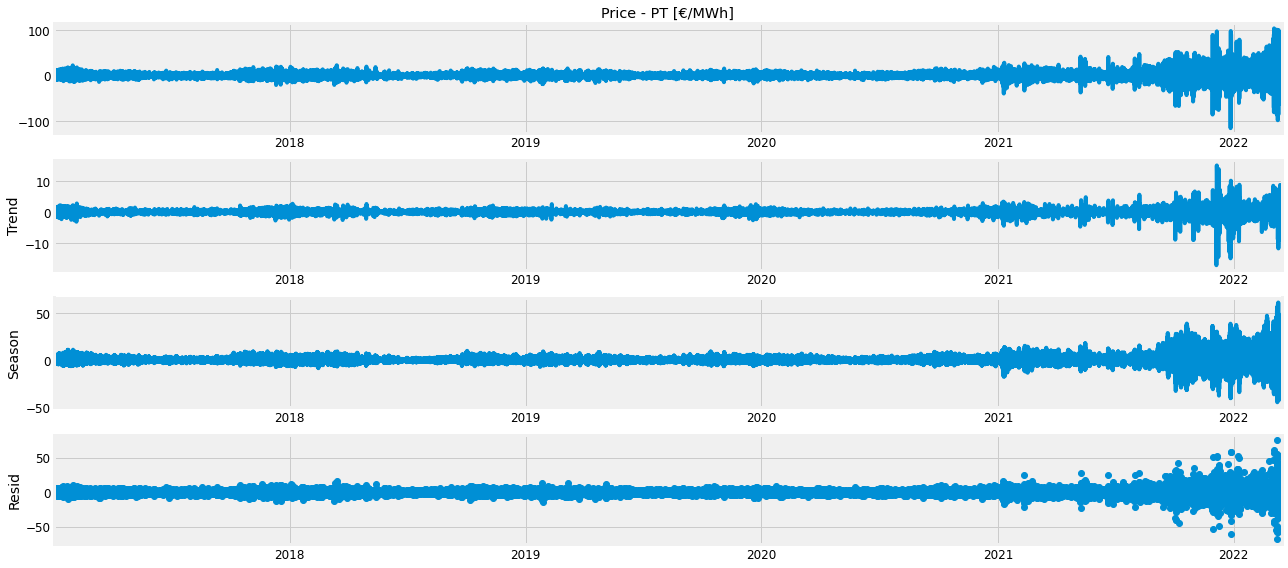

In [ ]:
rcParams['figure.figsize'] = 18, 8
stl = STL(dfPricePT1, period=12)
res = stl.fit()
fig = res.plot()
plt.show()

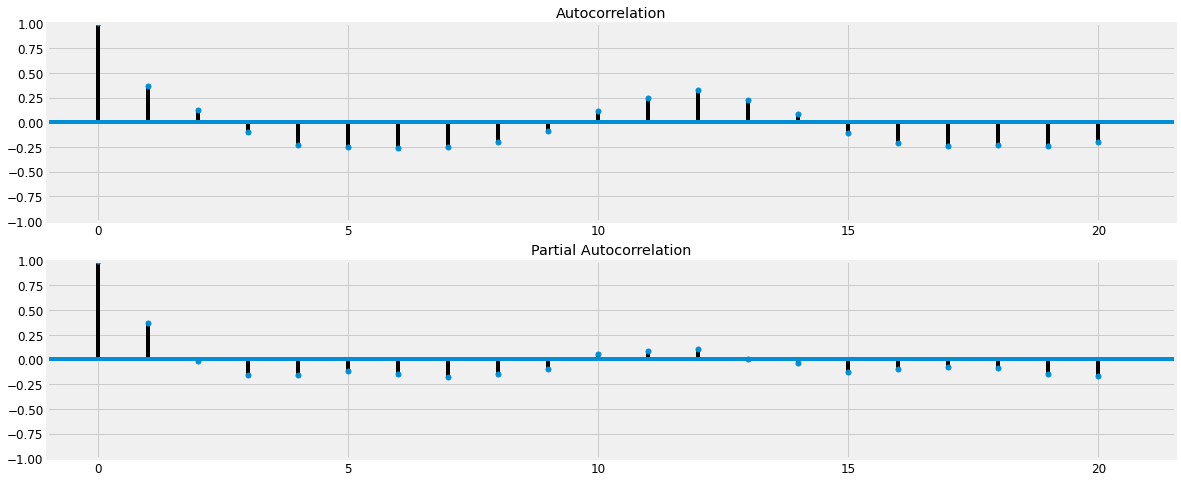

In [ ]:
import statsmodels.api as sm

fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(dfPricePT1.values, lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(dfPricePT1.values, lags=20, ax=ax[1])
plt.show()